In [1]:
from collections import defaultdict
import random
random.seed(42)
import matplotlib.pyplot as plt

In [2]:
artists = []
artist_names = []
with open('./assignment2-data/artists.dat') as f:
    for l in f.readlines()[1:]:
        artists.append(int(l.split('\t')[0]))
        artist_names.append(l.split('\t')[1])
print(len(artists))
print(len(artist_names))

17632
17632


In [3]:
users = set()
interactions = []
with open('./assignment2-data/user_artists.dat') as f:
    for l in f.readlines()[1:]:
        row = l.split()
        users.add(int(row[0]))
        interactions.append((int(row[0]), int(row[1]), row[2], True))

In [4]:
user_friends = defaultdict(set)
with open('./assignment2-data/user_friends.dat') as f:
    for l in f.readlines()[1:]:
        u1, u2 = l.split()
        user_friends[int(u1)].add(int(u2))
        user_friends[int(u2)].add(int(u1))

In [5]:
tags = []
tag_names = []
with open('./assignment2-data/tags.dat', encoding = "ISO-8859-1") as f:
    for l in f.readlines()[1:]:
        row = l.split('\t')
        tags.append(row[0])
        tag_names.append(row[1])
print(len(tags))
print(len(tag_names))

11946
11946


In [6]:
artist_tags = defaultdict(set)
with open('./assignment2-data/user_taggedartists.dat',encoding = "ISO-8859-1") as f:
    for l in f.readlines()[1:]:
        row = l.split('\t')
        artist=int(row[1])
        tag = int(row[2])
        artist_tags[artist].add(tag)

In [7]:
artistsPerUser = defaultdict(set)
for i in interactions:
    user, artist, cnt, _ = i
    artistsPerUser[user].add(artist)

# Known statistics on dataset (https://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt)

- 1892 users
- 17632 artists
- 12717 user-user friendships (avg of 13.4 friends per user)
- 92834 user-artist interactions (avg of 5.265 users per artist)

In [8]:
#Negative Sampling
sampled_interactions = []
for i in interactions:
    user, artist, cnt, label = i
    sampled_interactions.append(i)
    while True:
        neg_artist = random.sample(artists,1)[0]
        if neg_artist not in artistsPerUser[user]:
            sampled_interactions.append((user, neg_artist,0, False))
            artistsPerUser[user].add(neg_artist)
            break

random.shuffle(sampled_interactions)
train = sampled_interactions[:int(0.8*len(sampled_interactions))]
test = sampled_interactions[int(0.8*len(sampled_interactions)):]

# Popularity Analysis
## Has the potential to be a good predictor

In [9]:
artistCount = defaultdict(int)
totalListened = 0

for pt in train:
    (user, artist, _,label) = pt
    if label:
        artistCount[artist] += 1
        totalListened += 1

In [10]:
mostPopular = [(artistCount[x], x) for x in artistCount]
mostPopular.sort()
mostPopular.reverse()
for i in mostPopular[:10]:
    cnt, artist_id = i
    artist_name = artist_names[artists.index(artist_id)]
    print('Artist: ', artist_name, '     Number of users that listened to artist: ', cnt)

Artist:  Lady Gaga      Number of users that listened to artist:  492
Artist:  Britney Spears      Number of users that listened to artist:  399
Artist:  Rihanna      Number of users that listened to artist:  393
Artist:  The Beatles      Number of users that listened to artist:  381
Artist:  Katy Perry      Number of users that listened to artist:  377
Artist:  Madonna      Number of users that listened to artist:  346
Artist:  Paramore      Number of users that listened to artist:  335
Artist:  Avril Lavigne      Number of users that listened to artist:  328
Artist:  Christina Aguilera      Number of users that listened to artist:  327
Artist:  Beyoncé      Number of users that listened to artist:  316


In [11]:
pops = []
labels = []
for pt in train:
    user, artist, _, label = pt
    labels.append(label)
    pops.append(artistCount[artist])

Average popularity when label is False:  4.030810927429141


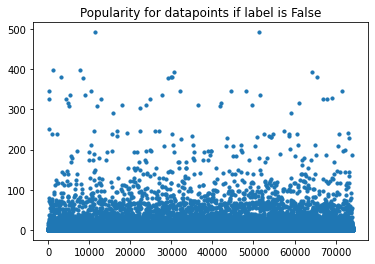

In [12]:
pops_for_neg = [pop for pop,label in zip(pops,labels) if not label]
avg_pop_for_neg = sum(pops_for_neg)/len(pops_for_neg)
print("Average popularity when label is False: ", avg_pop_for_neg)
plt.scatter(x=[i for i in range(len(pops_for_neg))],y=pops_for_neg, s=10)
plt.title('Popularity for datapoints if label is False')
plt.show()

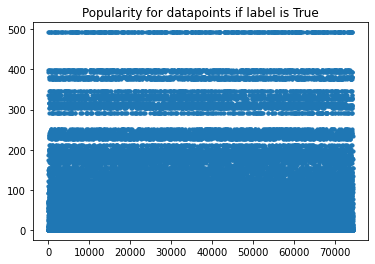

Average popularity when label is True:  68.77940622815038


In [13]:
pops_for_pos = [pop for pop,label in zip(pops,labels) if label]
avg_pop_for_pos = sum(pops_for_pos)/len(pops_for_pos)
plt.scatter(x=[i for i in range(len(pops_for_pos))],y=pops_for_pos, s=10)
plt.title('Popularity for datapoints if label is True')
plt.show()
print("Average popularity when label is True: ", avg_pop_for_pos)

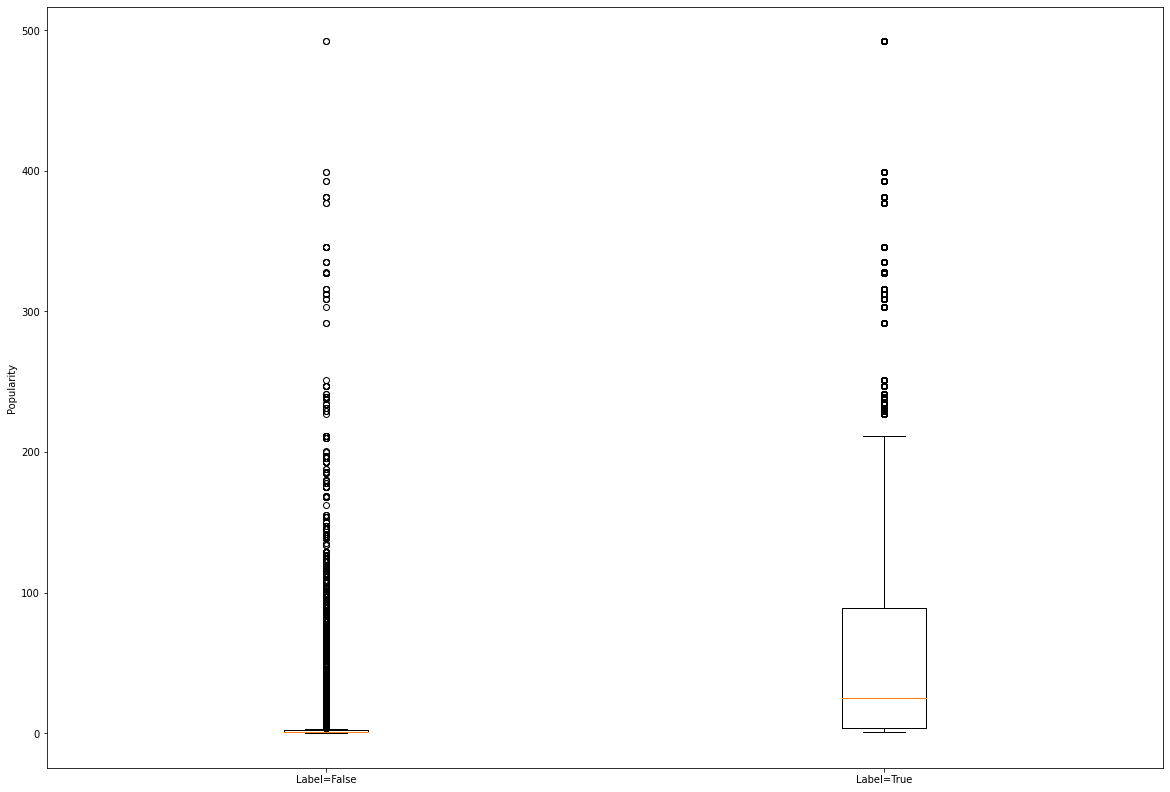

In [14]:
plot_data = [pops_for_neg, pops_for_pos]
fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(111)
bp = ax.boxplot(plot_data)
ax.set_xticklabels(['Label=False', 'Label=True'])
ax.set_ylabel('Popularity')
plt.show()

# Similarity Analysis
## Has the potential to be a good predictor

In [15]:
artistsByUser = defaultdict(set)
usersByArtist = defaultdict(set)

for pt in train:
    user, artist, _, label = pt
    if label:
        artistsByUser[user].add(artist)
        usersByArtist[artist].add(user)

In [16]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [17]:
def predict_jaccard(user, g):
    users_g = usersByArtist[g]
    g_dash = artistsByUser[user]
    similarities=[]
    for g_d in g_dash:
        if g_d == g: continue
        sim = Jaccard(users_g, usersByArtist[g_d])
        similarities.append(sim)
    if not similarities:
        similarities.append(0)
    return max(similarities)

In [18]:
sims = []
labels = []
for pt in train:
    user, artist, _, label = pt
    labels.append(label)
    sims.append(predict_jaccard(user,artist))

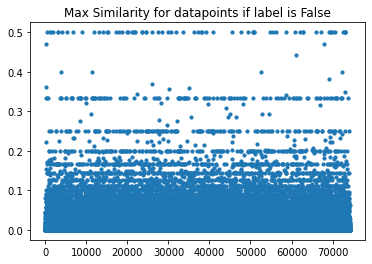

Average Jaccard Similarity when label is False:  0.013734727727925925


In [19]:
sims_for_neg = [sim for sim,label in zip(sims,labels) if not label]
plt.scatter(x=[i for i in range(len(sims_for_neg))],y=sims_for_neg, s=10)
plt.title('Max Similarity for datapoints if label is False')
plt.show()
avg_sim_for_neg = sum(sims_for_neg)/len(sims_for_neg)
print("Average Jaccard Similarity when label is False: ", avg_sim_for_neg)

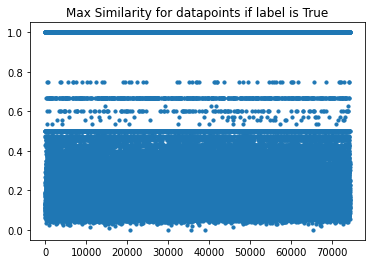

Average Jaccard Similarity when label is True:  0.3222174136379801


In [20]:
sims_for_pos = [sim for sim,label in zip(sims,labels) if label]
plt.scatter(x=[i for i in range(len(sims_for_pos))],y=sims_for_pos, s=10)
plt.title('Max Similarity for datapoints if label is True')
plt.show()
avg_sim_for_pos = sum(sims_for_pos)/len(sims_for_pos)
print("Average Jaccard Similarity when label is True: ", avg_sim_for_pos)

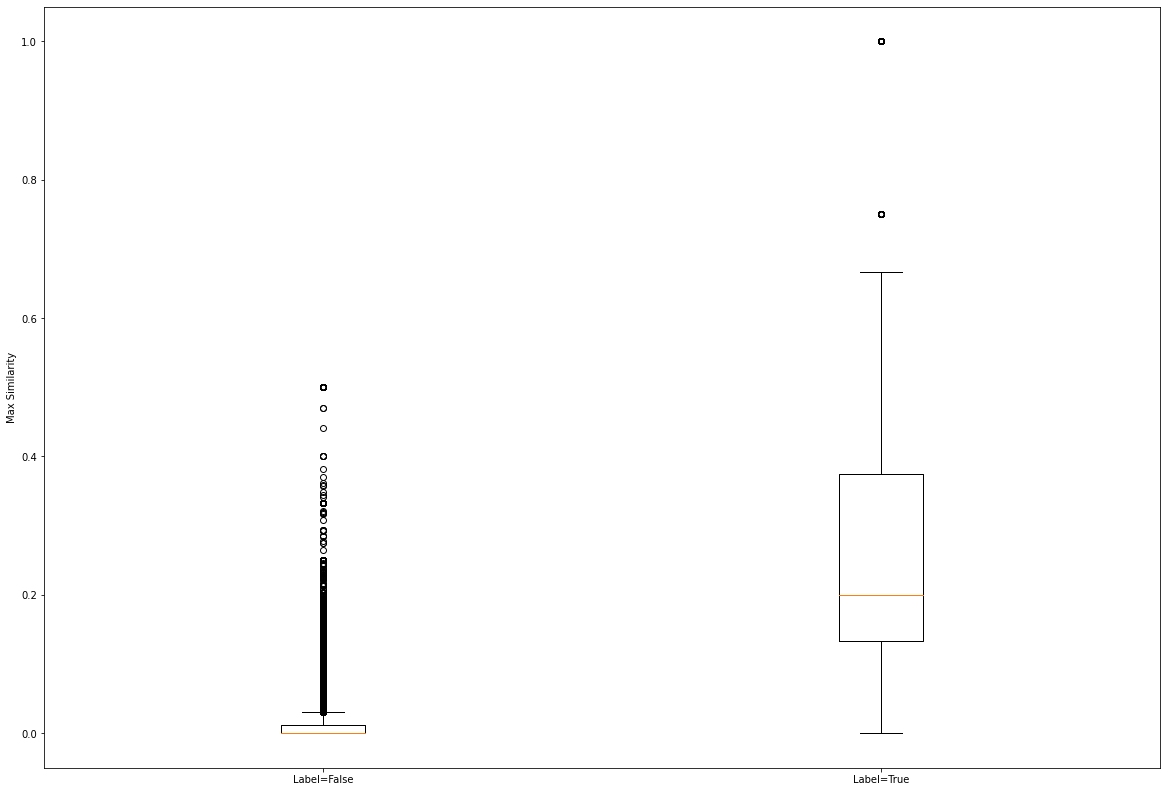

In [21]:
plot_data = [sims_for_neg, sims_for_pos]
fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(111)
bp = ax.boxplot(plot_data)
ax.set_xticklabels(['Label=False', 'Label=True'])
ax.set_ylabel('Max Similarity')
plt.show()

# Tag based similarity

In [22]:
def predict_jaccard_tag(user, g):
    g_dash = artistsByUser[user]
    similarities = []
    for g_d in g_dash:
        if g_d == g: continue
        sim = Jaccard(artist_tags[g], artist_tags[g_d])
        similarities.append(sim)
    if not similarities:
        similarities.append(0)
    return max(similarities)

In [23]:
tag_sims = []
labels = []
for pt in train:
    user, artist, _, label = pt
    labels.append(label)
    tag_sims.append(predict_jaccard_tag(user,artist))

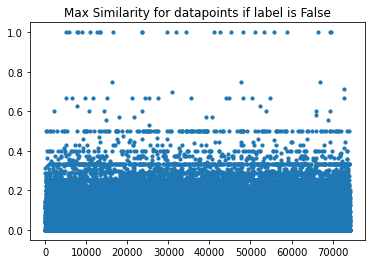

Average Jaccard Similarity when label is False:  0.056319815783277466


In [24]:
sims_for_neg = [sim for sim,label in zip(tag_sims,labels) if not label]
plt.scatter(x=[i for i in range(len(sims_for_neg))],y=sims_for_neg, s=10)
plt.title('Max Similarity for datapoints if label is False')
plt.show()
avg_sim_for_neg = sum(sims_for_neg)/len(sims_for_neg)
print("Average Jaccard Similarity when label is False: ", avg_sim_for_neg)

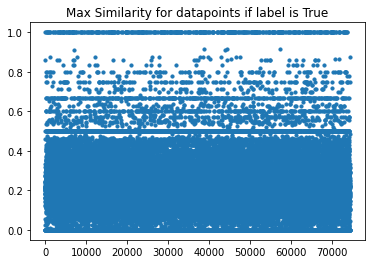

Average Jaccard Similarity when label is True:  0.22495219930822416


In [25]:
sims_for_pos = [sim for sim,label in zip(tag_sims,labels) if label]
plt.scatter(x=[i for i in range(len(sims_for_pos))],y=sims_for_pos, s=10)
plt.title('Max Similarity for datapoints if label is True')
plt.show()
avg_sim_for_pos = sum(sims_for_pos)/len(sims_for_pos)
print("Average Jaccard Similarity when label is True: ", avg_sim_for_pos)

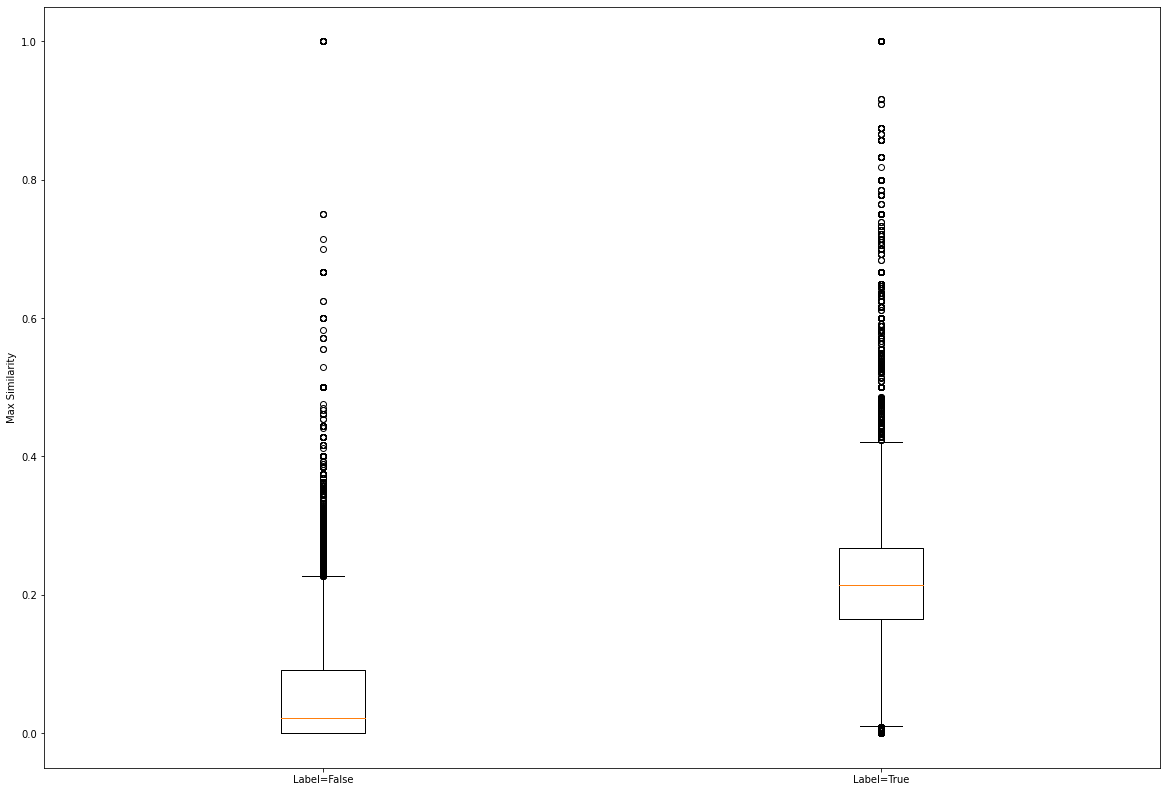

In [26]:
plot_data = [sims_for_neg, sims_for_pos]
fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(111)
bp = ax.boxplot(plot_data)
ax.set_xticklabels(['Label=False', 'Label=True'])
ax.set_ylabel('Max Similarity')
plt.show()

# Friendship Analysis
## Has the potential to be a good predictor

In [27]:
friends_who_listen = []
labels = []
for pt in train:
    user, artist, _, label = pt
    labels.append(label)
    s=0
    for friend in user_friends[user]:
        if artist in artistsByUser[friend]:
            s+=1
    friends_who_listen.append(s)

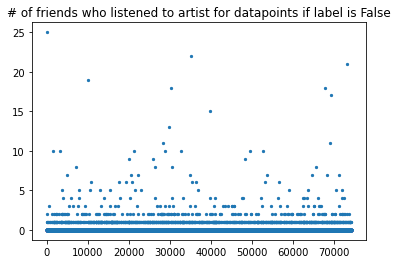

Average # of friends who listen to artist when label is False:  0.025970173404169253


In [28]:
friends_for_neg = [friend_count for friend_count,label in zip(friends_who_listen,labels) if not label]
plt.scatter(x=[i for i in range(len(friends_for_neg))],y=friends_for_neg, s=5)
plt.title('# of friends who listened to artist for datapoints if label is False')
plt.show()
avg_friends_for_neg = sum(friends_for_neg)/len(friends_for_neg)
print("Average # of friends who listen to artist when label is False: ", avg_friends_for_neg)

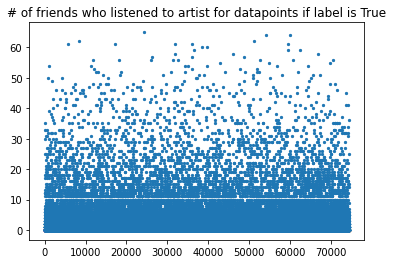

Average # of friends who listen to artist when label is True:  1.9028666702522454


In [29]:
friends_for_pos = [friend_count for friend_count,label in zip(friends_who_listen,labels) if label]
avg_friends_for_pos = sum(friends_for_pos)/len(friends_for_pos)
plt.scatter(x=[i for i in range(len(friends_for_pos))],y=friends_for_pos, s=5)
plt.title('# of friends who listened to artist for datapoints if label is True')
plt.show()
print("Average # of friends who listen to artist when label is True: ", avg_friends_for_pos)

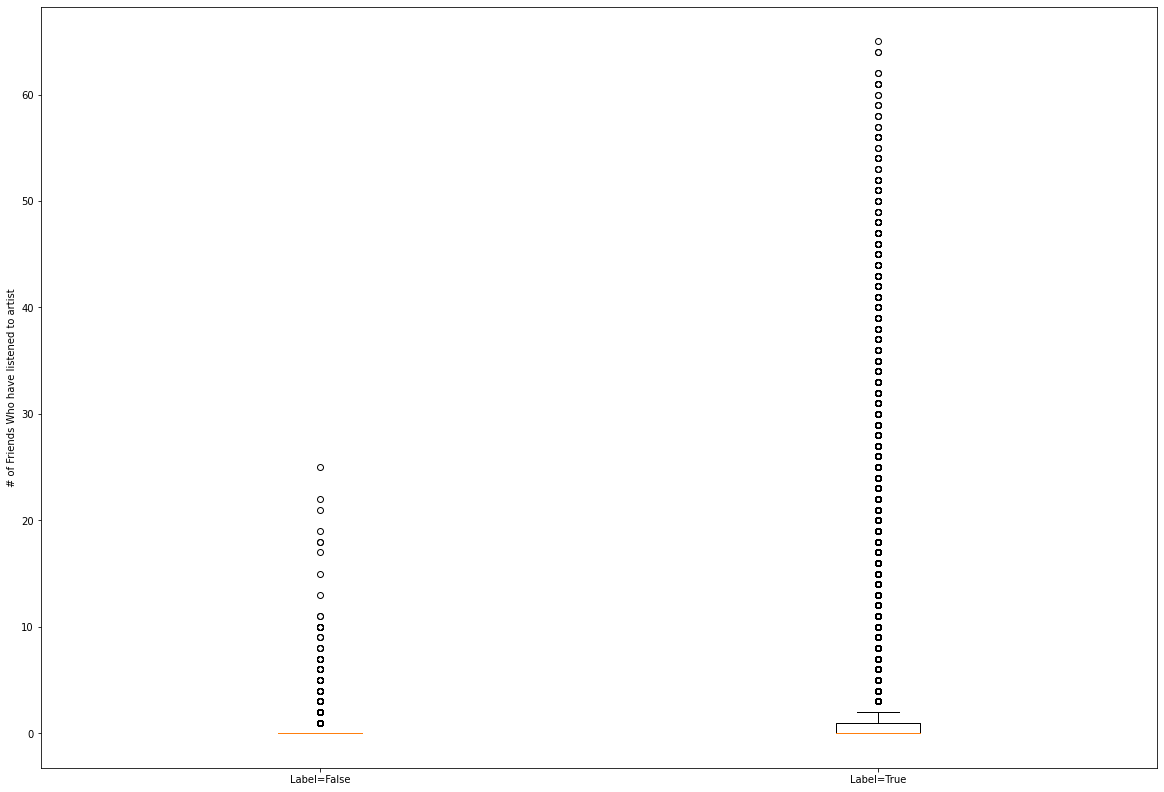

In [30]:
plot_data = [friends_for_neg, friends_for_pos]
fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(111)     
bp = ax.boxplot(plot_data)
ax.set_xticklabels(['Label=False', 'Label=True'])
ax.set_ylabel('# of Friends Who have listened to artist')
plt.show()

# Baseline Heuristic Model
Predict YES if one of these 3 conditions are satisfied:
- One of user's friends listens to said artist
- If the artist has a 0.3 jaccard similarity to any of the artists the user listens to
- If the artist is among the most popular 25% of artists

In [31]:
userDict = defaultdict(list)
listenDict = defaultdict(list)
artistDict = defaultdict(list)
artistListenDict = defaultdict(list)
all_data = []

for user, artist, times, label in train:
    if label:
        userDict[user].append(artist)
        artistDict[artist].append(user)


In [32]:
topArtistListens = sorted([(k, len(v)) for k, v in artistDict.items()], key = lambda x: x[1], reverse = True)
popular_artists = [k for k, v in topArtistListens][:int(len(topArtistListens)*0.25//1)]

In [33]:
predictions = []
actual = []
for v in test:
    user = v[0]
    artist = v[1]
    if v[2]:
        actual.append(1)
    else:
        actual.append(0)
    pred = 0
    for friend in user_friends[user]:
        if artist in set(user_friends[friend]):
            pred = 1
            break
    for a2 in userDict[user]:
        if a2 == artist:
            continue
        sim = Jaccard(set(artistDict[a2]), set(artistDict[artist]))
        if sim >= 0.3:
            pred = 1
    if artist in set(popular_artists):
        pred = 1
    predictions.append(pred)

In [34]:
count = 0
for i in range(len(predictions)):
    if predictions[i] == actual[i]:
        count += 1
print("Test Accuracy is:", round(count/len(predictions), 3))

Test Accuracy is: 0.786


# Experiments

## Experiment 1 Logistic Regressor (Features: Popularity, Max Sim, Friend Count)

In [35]:
def create_features(data, use_pop=True, use_sim=True, use_friends=True, use_tag_sim=True):
    feats = []
    y = []
    for d in data:
        feat_vec = []
        user, artist, _, label = d
        y.append(label)
        if use_pop:
            feat_vec.append(artistCount[artist])
        if use_sim:
            max_sim = predict_jaccard(user,artist)
            feat_vec.append(max_sim)
        if use_tag_sim:
            max_tag_sim = predict_jaccard_tag(user,artist)
            feat_vec.append(max_tag_sim)
        if use_friends:
            friend_cnt = 0
            for friend in user_friends[user]:
                if artist in artistsByUser[friend]:
                    friend_cnt+=1
            feat_vec.append(friend_cnt)
        feats.append(feat_vec)
    return feats, y

In [36]:
def compute_accuracy(preds, ys):
    correct = sum([pred==y for pred,y in zip(preds,ys)])
    return correct/len(ys)

In [37]:
X_train, Y_train = create_features(train)
X_test, Y_test = create_features(test)

In [38]:
from sklearn import linear_model

In [39]:
log_reg = linear_model.LogisticRegression(C=1e-1, class_weight='balanced', fit_intercept=True, max_iter=50)
log_reg.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=50)

In [40]:
train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)
print(f'Train Accuracy: {compute_accuracy(train_preds, Y_train)}')
print(f'Test Accuracy: {compute_accuracy(test_preds, Y_test)}')
print(f'Theta {log_reg.coef_}')
print(f'Intercept {log_reg.intercept_}')

Train Accuracy: 0.9629377785557516
Test Accuracy: 0.845424678192492
Theta [[ 0.04152022 21.79007362  8.85756366  0.47580816]]
Intercept [-4.21640612]


# Ablations

## Exclude Popularity

In [41]:
X_traina, Y_train = create_features(train, use_pop=False)
X_testa, Y_test = create_features(test, use_pop=False)

In [42]:
log_rega = linear_model.LogisticRegression(C=1e-1, class_weight='balanced', fit_intercept=True)
log_rega.fit(X_traina, Y_train)
train_preds = log_rega.predict(X_traina)
test_preds = log_rega.predict(X_testa)
print(f'Train Accuracy: {compute_accuracy(train_preds, Y_train)}')
print(f'Test Accuracy: {compute_accuracy(test_preds, Y_test)}')
print(f'Theta {log_rega.coef_}')
print(f'Intercept {log_rega.intercept_}')

Train Accuracy: 0.9549194123904291
Test Accuracy: 0.8522378413313945
Theta [[25.09833686 10.47363898  0.89830911]]
Intercept [-3.88392546]


## Exclude Sim

In [43]:
X_trainb, Y_train = create_features(train, use_sim=False)
X_testb, Y_test = create_features(test, use_sim=False)

In [44]:
log_regb = linear_model.LogisticRegression(C=1e-1, class_weight='balanced', fit_intercept=True)
log_regb.fit(X_trainb, Y_train)
train_preds = log_regb.predict(X_trainb)
test_preds = log_regb.predict(X_testb)
print(f'Train Accuracy: {compute_accuracy(train_preds, Y_train)}')
print(f'Test Accuracy: {compute_accuracy(test_preds, Y_test)}')
print(f'Theta {log_regb.coef_}')
print(f'Intercept {log_regb.intercept_}')

Train Accuracy: 0.864313894461874
Test Accuracy: 0.8677761620078634
Theta [[ 0.0329229  10.9823412   0.93873594]]
Intercept [-2.16912841]


# Exclude Tag Sim

In [45]:
X_traine, Y_train = create_features(train, use_tag_sim = False)
X_teste, Y_train = create_features(test, use_tag_sim = False)

In [46]:
log_rege = linear_model.LogisticRegression(C=1e-1, class_weight='balanced', fit_intercept=True)
log_rege.fit(X_traine, Y_train)
train_preds = log_rege.predict(X_traine)
test_preds = log_rege.predict(X_teste)
print(f'Train Accuracy: {compute_accuracy(train_preds, Y_train)}')
print(f'Test Accuracy: {compute_accuracy(test_preds, Y_test)}')
print(f'Theta {log_rege.coef_}')
print(f'Intercept {log_rege.intercept_}')

ValueError: Found input variables with inconsistent numbers of samples: [148534, 37134]

## Exclude Friend Count

In [47]:
X_trainc, Y_train = create_features(train, use_friends=False)
X_testc, Y_test = create_features(test, use_friends=False)

In [48]:
log_regc = linear_model.LogisticRegression(C=1e-1, class_weight='balanced', fit_intercept=True)
log_regc.fit(X_trainc, Y_train)
train_preds = log_regc.predict(X_trainc)
test_preds = log_regc.predict(X_testc)
print(f'Train Accuracy: {compute_accuracy(train_preds, Y_train)}')
print(f'Test Accuracy: {compute_accuracy(test_preds, Y_test)}')
print(f'Theta {log_regc.coef_}')
print(f'Intercept {log_regc.intercept_}')

Train Accuracy: 0.9631734148410465
Test Accuracy: 0.8449399472181828
Theta [[ 0.04534478 22.25169781  8.98508053]]
Intercept [-4.23057373]


## Exclude everything but sim

In [49]:
X_traind, Y_train = create_features(train, use_friends=False, use_pop = False)
X_testd, Y_test = create_features(test, use_friends=False, use_pop = False)

In [50]:
log_regd = linear_model.LogisticRegression(C=5e-2, class_weight='balanced', fit_intercept=True, max_iter=5)
log_regd.fit(X_traind, Y_train)
train_preds = log_regd.predict(X_traind)
test_preds = log_regd.predict(X_testd)
print(f'Train Accuracy: {compute_accuracy(train_preds, Y_train)}')
print(f'Test Accuracy: {compute_accuracy(test_preds, Y_test)}')
print(f'Theta {log_regd.coef_}')
print(f'Intercept {log_regd.intercept_}')

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.9509741877280623
Test Accuracy: 0.85800075402596
Theta [[16.59441192  9.9460274 ]]
Intercept [-2.86398351]


In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC()
svc.fit(X_train, Y_train)

In [ ]:
train_preds = svc.predict(X_train)
test_preds = svc.predict(X_test)
print(f'Train Accuracy: {compute_accuracy(train_preds, Y_train)}')
print(f'Test Accuracy: {compute_accuracy(test_preds, Y_test)}')